<font size="3">Step 1: 
Convert contents from raw sensor datasets to code comprehensible format 
and output it to 'rawdata' folder</font>

In [2]:
import pandas as pd
import os
import glob

# Define the parent folder path
parent_folder = "./Datasets"

# Define the output folder path
output_folder = "./rawdata"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each CSV file in the input directory
total_rows = 0  # Variable to store the total number of data rows

# Iterate over the subfolders in the parent folder
for root, dirs, files in os.walk(parent_folder):
    # Iterate over the subfolders
    for subfolder in dirs:
        # Get the full path of the subfolder
        subfolder_path = os.path.join(root, subfolder)

        # Get a list of all CSV files in the subfolder
        csv_files = glob.glob(os.path.join(subfolder_path, '*.csv'))
        
        # Iterate over each CSV file
        for file in csv_files:
            # Specify the data types for the columns
            dtypes = {'Status (hex)': int}
            
            # Import the excel file and get it to a dataframe
            df = pd.read_csv(file, skiprows=6)
            df = df.shift(axis=1)
            
            # Remove whitespaces from column names
            df.columns = df.columns.str.strip()
            
            # Select only the RDTSequence, Fx, Fy, and Fz columns
            df = df.loc[:,['RDTSequence', 'Fx', 'Fy', 'Fz']]

            # Convert RDTSequence to Actual time by formula RDTSequence/RDT Sample Rate
            df.iloc[:,0] = (df.iloc[:,0] - df.iloc[0,0]) / 125

            # Rename RDTSequence to Time Elapsed
            df = df.rename(columns={'RDTSequence': 'Time Elapsed'})

            # Modify 'Fz' values to absolute values
            df['Fz'] = df['Fz'].abs()

            # Add columns for Tangential force and Frictional coefficient to the dataframe
            df['Tangential Force'] = (df['Fx']**2 + df['Fy']**2)**0.5
            df['Frictional Coefficient'] = df['Tangential Force'] / df['Fz']

            # Extract the folder names from the file path
            folders = file.split(os.sep)
            folder_names = folders[-4:-1]  # Extract the desired folder names

            # Create the modified file name
            file_name = '_'.join(folder_names) + '_' + str(folders[-1][:-4]) + '.csv'
                       
            # Extract TCP Speed from the file name
            tcp_speed = os.path.basename(file_name).split("_")[2].split()[0]
            
            # Add a "TCP Speed" column with the material name to the DataFrame
            df["TCP Speed"] = tcp_speed
            
            # Split the file name using underscores and extract the material name
            material_name = os.path.basename(file_name).split("_")[0]            
    
            # Add a "Material" column with the material name to the DataFrame
            df["Material"] = material_name
                      
            # Save the modified DataFrame to the output folder
            output_path = os.path.join(output_folder, file_name)
            df.to_csv(output_path, index=False)
            
            # Increment the total number of data rows
            total_rows += len(df)

# Print the summation of data rows
print("Total number of data rows:", total_rows)


Total number of data rows: 423550


<font size="3">Step 2: Sort out datasets that has Frictional Coefficient within 1st and 3rd quartile and output 
        them to 'rawdata_quartiled' folder.</font>

In [3]:
import os
import pandas as pd

# Set the input and output directories
input_dir = r'.\rawdata'
output_dir = r'.\rawdata_quartiled'


# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Process each CSV file in the input directory
total_rows = 0  # Variable to store the total number of data rows

# Process each CSV file in the input directory
for file_name in os.listdir(input_dir):
    if file_name.endswith('.csv'):
        # Load the input data
        file_path = os.path.join(input_dir, file_name)
        df = pd.read_csv(file_path)

        # Compute the lower and upper bounds based on the 25th and 75th percentiles
        q1 = df['Frictional Coefficient'].quantile(0.25)
        q3 = df['Frictional Coefficient'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 0.25 * iqr
        upper_bound = q3 + 0.25 * iqr

        # Filter the dataset based on the range
        filtered_df = df[(df['Frictional Coefficient'] >= lower_bound) & (df['Frictional Coefficient'] <= upper_bound)]

        # Save the filtered dataset to the output directory
        output_file_path = os.path.join(output_dir, file_name)
        filtered_df.to_csv(output_file_path, index=False)
        
        # Increment the total number of data rows
        total_rows += len(filtered_df)
        
# Print the summation of data rows
print("Total number of data rows:", total_rows)


Total number of data rows: 289485


<font size="3">Step 3.a: Add new parameter columns to raw dataset and output them to preprocessed dataset\unfiltered dataset\full_dataset</font>

In [4]:
import os
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

# Set the input and output directories
input_dir = r'.\rawdata'
output_dir = r'.\preprocessed dataset\unfiltered dataset\full_dataset'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Process each CSV file in the input directory
for file_name in os.listdir(input_dir):
    if file_name.endswith('.csv'):
        # Load the input data
        file_path = os.path.join(input_dir, file_name)
        df = pd.read_csv(file_path)

        # Compute variance of Fx, Fy, and Fz
        df['Var_Fx'] = df['Fx'].var()
        df['Var_Fy'] = df['Fy'].var()
        df['Var_Fz'] = df['Fz'].var()

        # Compute correlation of Fx-Fy, Fx-Fz, and Fy-Fz pairs
        df['Corr_FxFy'] = df['Fx'].corr(df['Fy'])
        df['Corr_FxFz'] = df['Fx'].corr(df['Fz'])
        df['Corr_FyFz'] = df['Fy'].corr(df['Fz'])
        
        # Compute element-wise variance for Fx, Fy, Fz
        df['VarE_Fx'] = (df['Fx'] - df['Fx'].mean()) / (df.shape[0] - 1)
        df['VarE_Fy'] = (df['Fy'] - df['Fy'].mean()) / (df.shape[0] - 1)
        df['VarE_Fz'] = (df['Fz'] - df['Fz'].mean()) / (df.shape[0] - 1)
        
        # Compute correlation for Fx-Fy, Fx-Fz, Fy-Fz
        df['CorrE_FxFy'] = (df['Fx'] - df['Fx'].mean()) * (df['Fy'] - df['Fy'].mean()) / ((df.shape[0] - 1) * df['Fx'].std() * df['Fy'].std())
        df['CorrE_FxFz'] = (df['Fx'] - df['Fx'].mean()) * (df['Fz'] - df['Fz'].mean()) / ((df.shape[0] - 1) * df['Fx'].std() * df['Fz'].std())
        df['CorrE_FyFz'] = (df['Fy'] - df['Fy'].mean()) * (df['Fz'] - df['Fz'].mean()) / ((df.shape[0] - 1) * df['Fy'].std() * df['Fz'].std())
    
        # Calculate the density of (Fz, Frictional Coefficient) data pair
        xy = np.vstack([df['Fz'], df['Frictional Coefficient']])
        density = gaussian_kde(xy)(xy)
        df['Frictional Coefficient Density'] = density

        # Move the Material column to the rightmost end
        material_col = df.pop('Material')
        df['Material'] = material_col

        # Save the new dataset to the output directory
        output_file_path = os.path.join(output_dir, file_name)
        df.to_csv(output_file_path, index=False)


<font size="3">Step 3.b: Add new parameter columns to quartiled raw dataset and output them to \filtered dataset\full_dataset</font>

In [38]:
import os
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

# Set the input and output directories
input_dir = r'.\rawdata_quartiled'
output_dir = r'.\preprocessed dataset\filtered dataset\full_dataset'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Process each CSV file in the input directory
for file_name in os.listdir(input_dir):
    if file_name.endswith('.csv'):
        # Load the input data
        file_path = os.path.join(input_dir, file_name)
        df = pd.read_csv(file_path)

        # Compute variance of Fx, Fy, and Fz
        df['Var_Fx'] = df['Fx'].var()
        df['Var_Fy'] = df['Fy'].var()
        df['Var_Fz'] = df['Fz'].var()

        # Compute correlation of Fx-Fy, Fx-Fz, and Fy-Fz pairs
        df['Corr_FxFy'] = df['Fx'].corr(df['Fy'])
        df['Corr_FxFz'] = df['Fx'].corr(df['Fz'])
        df['Corr_FyFz'] = df['Fy'].corr(df['Fz'])
        
        # Compute element-wise variance for Fx, Fy, Fz
        df['VarE_Fx'] = (df['Fx'] - df['Fx'].mean()) / (df.shape[0] - 1)
        df['VarE_Fy'] = (df['Fy'] - df['Fy'].mean()) / (df.shape[0] - 1)
        df['VarE_Fz'] = (df['Fz'] - df['Fz'].mean()) / (df.shape[0] - 1)
        
        # Compute correlation for Fx-Fy, Fx-Fz, Fy-Fz
        df['CorrE_FxFy'] = (df['Fx'] - df['Fx'].mean()) * (df['Fy'] - df['Fy'].mean()) / ((df.shape[0] - 1) * df['Fx'].std() * df['Fy'].std())
        df['CorrE_FxFz'] = (df['Fx'] - df['Fx'].mean()) * (df['Fz'] - df['Fz'].mean()) / ((df.shape[0] - 1) * df['Fx'].std() * df['Fz'].std())
        df['CorrE_FyFz'] = (df['Fy'] - df['Fy'].mean()) * (df['Fz'] - df['Fz'].mean()) / ((df.shape[0] - 1) * df['Fy'].std() * df['Fz'].std())
    
        # Calculate the density of (Fz, Frictional Coefficient) data pair
        xy = np.vstack([df['Fz'], df['Frictional Coefficient']])
        density = gaussian_kde(xy)(xy)
        df['Frictional Coefficient Density'] = density

        # Move the Material column to the rightmost end
        material_col = df.pop('Material')
        df['Material'] = material_col

        # Save the new dataset to the output directory
        output_file_path = os.path.join(output_dir, file_name)
        df.to_csv(output_file_path, index=False)


<font size="3">Step 4.a: Create summary file for the unfiltered dataset in ./preprocessed dataset/unfiltered dataset/full_dataset_summary.csv</font>

In [6]:
import os
import pandas as pd

# Specify the directory path
data_dir = './preprocessed dataset/unfiltered dataset/full_dataset'

# Initialize an empty list to store the averages and material names
averages_list = []

# Process each CSV file in the directory
for file_name in os.listdir(data_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(data_dir, file_name)

        # Load the input data
        input_data = pd.read_csv(file_path)
        
        # Calculate the column-wise averages
        column_averages = input_data.mean(numeric_only=True)
        
        # Extract the unique value from the 'Material' column
        material_name = input_data['Material'].unique()[0]
        
        # Add a new column with the file name
        column_averages['File Name'] = file_name
        
        # Add a new column with the material name
        column_averages['Material'] = material_name
        
        # Append the column averages to the averages list
        averages_list.append(column_averages)

# Concatenate the averages into a single DataFrame
summary_df = pd.concat(averages_list, axis=1).T

# Set the 'File Name' and 'Material' columns as the first columns
summary_df = summary_df[['File Name', 'Material'] + list(summary_df.columns[:-2])]

# Save the summary DataFrame to a CSV file
summary_file_path = './preprocessed dataset/unfiltered dataset/full_dataset_summary.csv'
summary_df.to_csv(summary_file_path, index=False)

print("Summary CSV file saved at:", summary_file_path)


Summary CSV file saved at: ./preprocessed dataset/unfiltered dataset/full_dataset_summary.csv


<font size="3">Step 4.b: Create summary file for the filtered dataset in ./preprocessed dataset/filtered dataset/full_dataset_summary.csv</font>

In [7]:
import os
import pandas as pd

# Specify the directory path
data_dir = './preprocessed dataset/filtered dataset/full_dataset'

# Initialize an empty list to store the averages and material names
averages_list = []

# Process each CSV file in the directory
for file_name in os.listdir(data_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(data_dir, file_name)

        # Load the input data
        input_data = pd.read_csv(file_path)
        
        # Calculate the column-wise averages
        column_averages = input_data.mean(numeric_only=True)
        
        # Extract the unique value from the 'Material' column
        material_name = input_data['Material'].unique()[0]
        
        # Add a new column with the file name
        column_averages['File Name'] = file_name
        
        # Add a new column with the material name
        column_averages['Material'] = material_name
        
        # Append the column averages to the averages list
        averages_list.append(column_averages)

# Concatenate the averages into a single DataFrame
summary_df = pd.concat(averages_list, axis=1).T

# Set the 'File Name' and 'Material' columns as the first columns
summary_df = summary_df[['File Name', 'Material'] + list(summary_df.columns[:-2])]

# Save the summary DataFrame to a CSV file
summary_file_path = './preprocessed dataset/filtered dataset/full_dataset_summary.csv'
summary_df.to_csv(summary_file_path, index=False)

print("Summary CSV file saved at:", summary_file_path)


Summary CSV file saved at: ./preprocessed dataset/filtered dataset/full_dataset_summary.csv


<font size="4">Graphical Analysis Codes</font>

<font size="3">Graph plot for Fz vs Tangential Force in dataset summary files</font>

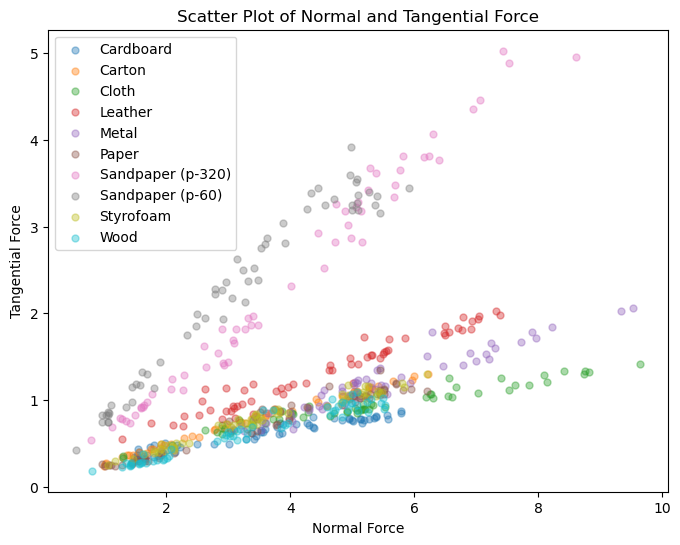

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file

# For filtered dataset: Comment line below if using unfiltered dataset
data = pd.read_csv(r'.\preprocessed dataset\filtered dataset\full_dataset_summary.csv') 

# For unfiltered dataset: Comment line below if using filtered dataset
#data = pd.read_csv(r'.\preprocessed dataset\unfiltered dataset\full_dataset_summary.csv') 

# List of unique materials
materials = data['Material'].unique()

# Set up the plot (for report)
#fig, ax = plt.subplots(figsize=(12, 8))
# Set up the plot (for IEEE)
fig, ax = plt.subplots(figsize=(8, 6))


# Iterate over each material and plot the corresponding data points
for material in materials:
    material_data = data[data['Material'] == material]
    ax.scatter(material_data['Fz'], material_data['Tangential Force'], label=material, alpha =0.4, s=25)

# Set labels and title
ax.set_xlabel('Normal Force')
ax.set_ylabel('Tangential Force')
ax.set_title('Scatter Plot of Normal and Tangential Force')

# Add a legend
ax.legend()

# Show the plot
plt.show()


<font size="3">Graph plot for Var_Fz vs Var_Fx in filtered dataset</font>

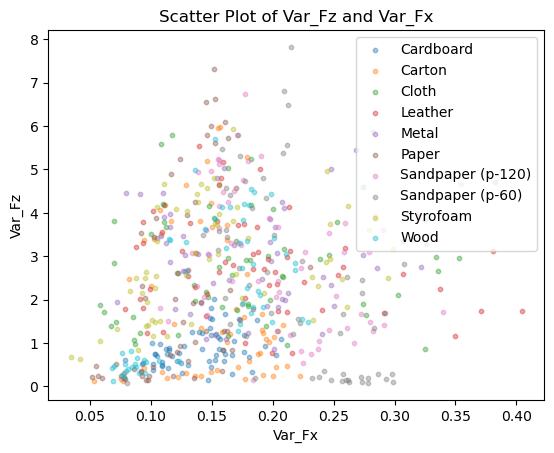

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# For filtered dataset: Comment line below if using unfiltered dataset
#data = pd.read_csv(r'.\preprocessed dataset\filtered dataset\full_dataset_summary.csv')

# For unfiltered dataset: Comment line below if using filtered dataset
data = pd.read_csv(r'.\preprocessed dataset\filtered dataset\full_dataset_summary.csv')

# List of unique materials
materials = data['Material'].unique()

# Set up the plot
fig, ax = plt.subplots()

# Iterate over each material and plot the corresponding data points
for material in materials:
    material_data = data[data['Material'] == material]
    ax.scatter(material_data['Var_Fx'], material_data['Var_Fz'], label=material, alpha =0.4, s=10)

# Set labels and title
ax.set_xlabel('Var_Fx')
ax.set_ylabel('Var_Fz')
ax.set_title('Scatter Plot of Var_Fz and Var_Fx')

# Add a legend
ax.legend()

# Show the plot
plt.show()


<font size="3">Graph plot for Frictional Coefficient vs Fz for specific material</font>

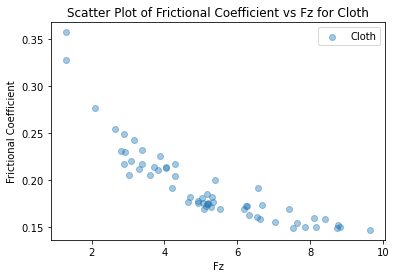

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# For filtered dataset: Comment line below if using unfiltered dataset
#data = pd.read_csv(r'.\preprocessed dataset\filtered dataset\full_dataset_summary.csv')

# For unfiltered dataset: Comment line below if using filtered dataset
data = pd.read_csv(r'.\preprocessed dataset\filtered dataset\full_dataset_summary.csv')

# Filter data for material
material_data = data[data['Material'] == 'Cloth']
# Set up the plot
fig, ax = plt.subplots()

# Plot the data points for material
ax.scatter(material_data['Fz'], material_data['Frictional Coefficient'], label=material_data['Material'].iloc[0], alpha=0.4)

# Set labels and title
ax.set_xlabel('Fz')
ax.set_ylabel('Frictional Coefficient')
ax.set_title('Scatter Plot of Frictional Coefficient vs Fz for ' + material_data['Material'].iloc[0])

# Add a legend
ax.legend()

# Show the plot
plt.show()


<font size="3">Graph plot for Tangential Force vs Fz for specific material</font>

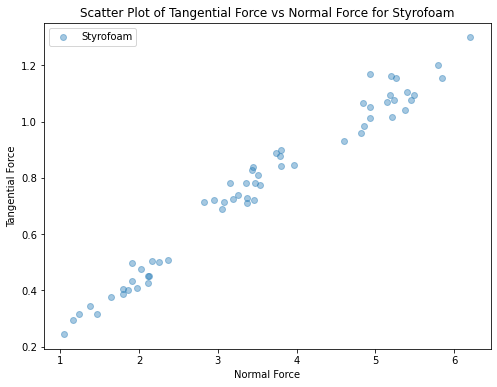

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# For filtered dataset: Comment line below if using unfiltered dataset
#data = pd.read_csv(r'.\preprocessed dataset\filtered dataset\full_dataset_summary.csv')

# For unfiltered dataset: Comment line below if using filtered dataset
data = pd.read_csv(r'.\preprocessed dataset\filtered dataset\full_dataset_summary.csv')

# Filter data for material
material_data = data[data['Material'] == 'Styrofoam']
# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data points for material
ax.scatter(material_data['Fz'], material_data['Tangential Force'], label=material_data['Material'].iloc[0], alpha=0.4)

# Set labels and title
ax.set_xlabel('Normal Force')
ax.set_ylabel('Tangential Force')
ax.set_title('Scatter Plot of Tangential Force vs Normal Force for ' + material_data['Material'].iloc[0])

# Add a legend
ax.legend()

# Show the plot
plt.show()
